# Visualize RNN Prediction

In [1]:
using Flux
using StaticArrays
using ProgressMeter
using POMDPs
using POMDPToolbox
using AutomotiveDrivingModels
using AutoViz
using AutomotivePOMDPs
using AutomotiveSensors
using PedCar
using Reel
using FileIO
using BSON: @load

In [16]:
cam = FitToContentCamera(0.)
rng = MersenneTwister(1);

**environment**

In [150]:
mdp = PedCarMDP(pos_res=2.0, vel_res=2., ped_birth=0.7, car_birth=0.7)
pomdp = UrbanPOMDP(env=mdp.env,
                    sensor = GaussianSensor(false_positive_rate=0.0, 
                                            pos_noise = LinearNoise(min_noise=0.5, increase_rate=0.05), 
                                            vel_noise = LinearNoise(min_noise=0.5, increase_rate=0.05)),
                   ego_goal = LaneTag(2, 1),
                   max_cars=1, 
                   max_peds=1, 
                   car_birth=0.7, 
                   ped_birth=0.7, 
                   max_obstacles=1, # no fixed obstacles
                   lidar=false,
                   ego_start=20,
                   ΔT=0.1);



In [16]:
n_models = 10
models = Vector{Chain}(n_models)
for i=0:n_models-1
    models[i+1] = BSON.load("model_$i.bson")[:model] 
end


In [9]:
# input_length = n_dims(pomdp)
# output_length = n_dims(pomdp)
# model = Chain(LSTM(input_length, 128),
#               Dense(128, output_length))

In [10]:
function process_prediction(b::Vector{Float64}, o::Vector{Float64})
    n_features = 4
    n_obstacles = 3
    b_ = zeros(length(o))
    b_[1:4] = o[1:4] # ego state fully observable
    b_[end - n_features*n_obstacles + 1:end] = o[end - n_features*n_obstacles + 1:end]
    b_[5:end - n_features*n_obstacles] = b
    return b_
end

process_prediction (generic function with 1 method)

In [11]:
n_steps = 400
belief_history = Vector{Vector{Float64}}[]
state_history = Scene[]
obs_history = Vector{Float64}[]
s = initial_state(pomdp, rng)
for m in models
    Flux.reset!(m)
end
@time for i=1:n_steps
    if isterminal(pomdp, s)
        break 
    end
    push!(state_history, s)
    a = UrbanAction(2.)
    o = generate_o(pomdp, s, a, s, rng)
    beliefs = Vector{Vector{Float64}}(n_models)
    for i=1:n_models       
        b = models[i](o).tracker.data
        b_ = process_prediction(b, o)
        beliefs[i] = b_
    end
    push!(belief_history, beliefs)
    push!(obs_history, o)
    sp = generate_s(pomdp, s, a, rng)
    s = sp
end


  1.496735 seconds (1.12 M allocations: 136.231 MiB, 5.58% gc time)


In [14]:
duration, fps, render_hist = animate_scenes(state_history, obs_history, belief_history, pomdp, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpwH7lwu", 0x0000000000000040, 10.0, nothing)

In [13]:
function AutomotivePOMDPs.animate_scenes(scenes::Vector{Scene}, observations::Vector{Vector{Float64}}, beliefs::Vector{Vector{Vector{Float64}}}, pomdp::UrbanPOMDP;
                                         sim_dt = 0.1,
                                         cam = StaticCamera(VecE2(0., -8.), 16.0))
    env = pomdp.env 
    duration = length(scenes)*sim_dt
    fps = Int(1/sim_dt)
    function render_rec(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        overlays = SceneOverlay[IDOverlay()]
        obs = [veh for veh in obs_to_scene(pomdp, observations[frame_index]) if veh.id != EGO_ID]
        obs_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=obs, color=MONOKAI["color2"])
        push!(overlays, obs_overlay)
        occlusion_overlay = OcclusionOverlay(obstacles=mdp.env.obstacles)
        push!(overlays, occlusion_overlay)
        for b in beliefs[frame_index]
            bel = [veh for veh in obs_to_scene(pomdp, b) if veh.id != EGO_ID]
            bel_overlay = GaussianSensorOverlay(sensor=pomdp.sensor, o=bel, color=MONOKAI["color4"])            
            push!(overlays, bel_overlay)
        end
        return AutoViz.render(scenes[frame_index], env, overlays, cam=cam)
    end
    return duration, fps, render_rec
end
    
    

## Visualize training set

In [144]:
include("data_generation.jl")

normalized_off_the_grid_pos (generic function with 1 method)

In [185]:
policy = RandomHoldPolicy(pomdp, 5, 0, UrbanAction(0.), rng);

In [212]:
X, Y = collect_set(pomdp, policy , 400, rng, 1);

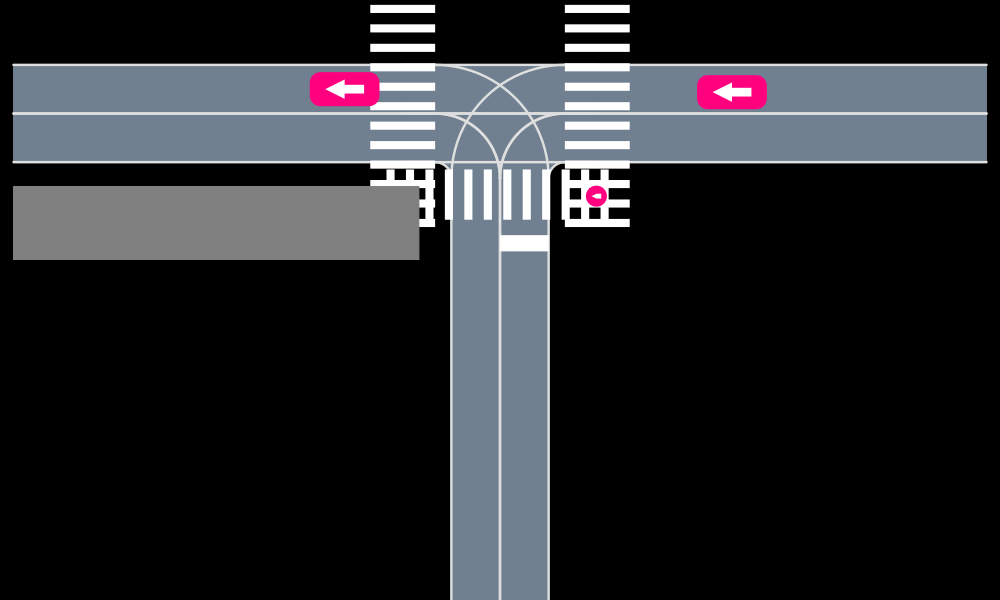

In [213]:
traj = X[1]
scenes = obs_to_scene.(pomdp, traj);
render(scenes[end], pomdp.env, cam=cam)

In [183]:
duration, fps, render_hist = animate_scenes(scenes, pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmprFg8TC", 0x0000000000000065, 10.0, nothing)

In [184]:
tx, ty = generate_trajectory(pomdp, policy, 100, rng);
tx = convert.(Vector{Float64}, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tx), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

101-element Array{Array{Float64,1},1}:
 [0.0625, -0.416667, 1.0, 0.0, 1.09683, 0.547539, 1.0, 0.920383, -0.103293, 0.228376, 0.0, 0.027537, 0.520833, 0.1875, -0.791667, 0.135417]      
 [0.0625, -0.416667, 1.0, 0.0, 1.13939, 0.577971, 1.0, 0.657247, -0.183094, 0.214236, 0.0, 0.0411595, 0.520833, 0.1875, -0.791667, 0.135417]     
 [0.0625, -0.416667, 1.0, 0.0, 1.0734, 0.652985, 1.0, 0.31494, -0.208985, 0.166325, 0.0, 0.108432, 0.520833, 0.1875, -0.791667, 0.135417]        
 [0.0625, -0.416667, 1.0, 0.0, 1.1444, 0.544815, 1.0, 0.131042, -0.102375, 0.177417, 0.0, 0.140879, 0.520833, 0.1875, -0.791667, 0.135417]       
 [0.0625, -0.416667, 1.0, 0.0, 1.0807, 0.421031, 1.0, 0.692703, -0.112204, 0.167201, 0.0, 0.0468391, 0.520833, 0.1875, -0.791667, 0.135417]      
 [0.0625, -0.416667, 1.0, 0.0, 1.15206, 0.575793, 1.0, 0.668817, -0.190557, 0.175918, 0.0, 0.127644, 0.520833, 0.1875, -0.791667, 0.135417]      
 [0.0625, -0.416667, 1.0, 0.0, 1.03238, 0.601425, 1.0, 0.786594, -0.144584, 0.215342,

In [157]:
tb = process_prediction.(pomdp, ty, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tb), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpXs6iwb", 0x0000000000000065, 10.0, nothing)

In [142]:
function process_prediction(pomdp::UrbanPOMDP, b::Vector{Float64}, o::Vector{Float64})
    n_features = 4
    n_obstacles = pomdp.max_obstacles
    b_ = zeros(length(o)) # should be 12 + obstacles
    b_[1:4] = o[1:4] # ego state fully observable
    # get car state from b
    car_presence = b[5]
    if 1/(1 + exp(-car_presence)) > 0.5 # softmax 
        b_[n_features+1:2*n_features] = b[1:4]
    else
        # absent
        b_[n_features+1:2*n_features] = normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
    
    # get ped state from b 
    ped_presence = b[10]
    if 1/(1 + exp(-ped_presence)) > 0.5 # softmax 
        b_[2*n_features+1:3*n_features] = b[6:9]
    else
        # absent 
        b_[2*n_features+1:3*n_features] = normalized_off_the_grid_pos(pomdp, o[1], o[2])
    end
            
    b_[end - n_features*n_obstacles + 1:end] = o[end - n_features*n_obstacles + 1:end]
    return b_
end

function normalized_off_the_grid_pos(pomdp::UrbanPOMDP,normalized_ego_x::Float64, normalized_ego_y::Float64)
    pos_off = get_off_the_grid(pomdp)
    max_ego_dist = get_end(pomdp.env.roadway[pomdp.ego_goal])
    return [pos_off.posG.x/max_ego_dist - normalized_ego_x, pos_off.posG.y/max_ego_dist - normalized_ego_y, pos_off.posG.θ, 0.]
end

normalized_off_the_grid_pos (generic function with 1 method)

In [143]:
tb = process_prediction.(pomdp, ty, tx)
duration, fps, render_hist = animate_scenes(obs_to_scene.(pomdp, tb), pomdp.env, sim_dt=pomdp.ΔT)
speed_factor = 1
film = roll(render_hist, fps = speed_factor*fps, duration = duration/speed_factor)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpcowIYf", 0x0000000000000006, 10.0, nothing)